In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import decoupler as dc
import seaborn as sns
import gseapy as gp
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
import scipy as sp
from plot_lib import *

In [2]:
#Okabe- Ito palette
pal = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F5C710", "#0072B2", "#D55E00", "#CC79A7", "#999999"]

# define top and bottom colormaps 
top = plt.get_cmap('Oranges_r', 128) # r means reversed version
bottom = plt.get_cmap('Blues', 128)# combine it all
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))# create a new colormaps with a name of OrangeBlue
orange_blue = colors.ListedColormap(newcolors, name='OrangeBlue')

In [3]:
color_pal = {}
for x in zip(["CollecTri", "M2Kb_K-562", "M2Kb_MCF-7", "M2Kb_HepG2", "M2Kb_GM-12878", "CA_K-562", "CA_MCF-7", "CA_HepG2", "CA_GM-12878"], 
             [pal[7], pal[2], pal[3], pal[4], pal[8], pal[1], pal[0], pal[5], pal[6]]):
    color_pal[x[0]] = colors.to_rgba(x[1])
    
cmap = matplotlib.colors.ListedColormap([pal[7], pal[2], pal[3], pal[4], pal[8], pal[1], pal[0], pal[5], pal[6]])
net_dict = {"CollecTri": 7, 
            "M2Kb_K-562": 2, 
            "M2Kb_MCF-7": 3, 
            "M2Kb_HepG2": 4, 
            "M2Kb_GM-12878": 8,
            "CA_K-562": 1,
            "CA_MCF-7": 0,
            "CA_HepG2": 5,
            "CA_GM-12878": 6}

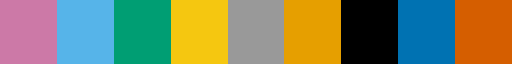

In [4]:
cmap

Network data loading

In [5]:
collectri = dc.get_collectri(organism='human', split_complexes=False)

In [6]:
chip_atlas_mcf7 = pd.read_table("../data/regulons/ChIP-Atlas_target_genes_MCF7.tsv", sep="\t")

In [7]:
mcf7 = pd.read_table("../data/regulons/MCF7_regulon.tsv", sep="\t")

mcf7 = mcf7.loc[mcf7.is_method_2 & mcf7.is_dnase, ["tf", "gene_symbol"]].drop_duplicates(["tf", "gene_symbol"])
mcf7 = mcf7.loc[mcf7.tf.isin(collectri.source) & mcf7.tf.isin(chip_atlas_mcf7.tf)]
mcf7.shape

(675587, 2)

In [8]:
chip_atlas_mcf7 = chip_atlas_mcf7.loc[chip_atlas_mcf7.tf.isin(mcf7.tf)]
chip_atlas_mcf7.shape

(2668469, 2)

In [9]:
collectri = collectri[collectri.source.isin(mcf7.tf)]

### Prepare cosmic

In [10]:
COSMIC = dc.get_resource('CancerGeneCensus')

COSMIC.tumour_types_somatic = COSMIC.tumour_types_somatic.str.split(";")

COSMIC = COSMIC.explode("tumour_types_somatic")
cosmic_dict = {}
for typ in COSMIC.tumour_types_somatic.drop_duplicates():
    if COSMIC.loc[COSMIC.tumour_types_somatic == typ].genesymbol.shape[0] > 1:
        cosmic_dict[typ] = COSMIC.loc[COSMIC.tumour_types_somatic == typ].genesymbol.to_list()

# BC dataset

In [11]:
adata_bc = sc.read_h5ad("../data/case_study/wu_et_al_brca.h5ad")

In [12]:
adata_bc.obs.Calls.value_counts()

no_scTYPER_call    75575
LumA_SC             7943
Basal_SC            6631
Her2_SC             5711
LumB_SC             4204
Name: Calls, dtype: int64

In [13]:
sc.pp.neighbors(adata_bc)
sc.tl.umap(adata_bc)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [14]:
adata_bc.obs.head()

,Patient,Percent_mito,nCount_RNA,nFeature_RNA,celltype_major,celltype_minor,celltype_subset,subtype,gene_module,Calls,normal_cell_call,CNA_value
CID3586_AAGACCTCAGCATGAG,CID3586,1.506221,4581,1689,Endothelial,Endothelial ACKR1,Endothelial ACKR1,HER2+,no_gene_module,no_scTYPER_call,no_inferCNV_call,no_CNA_value
CID3586_AAGGTTCGTAGTACCT,CID3586,5.793743,1726,779,Endothelial,Endothelial ACKR1,Endothelial ACKR1,HER2+,no_gene_module,no_scTYPER_call,no_inferCNV_call,no_CNA_value
CID3586_ACCAGTAGTTGTGGCC,CID3586,1.383238,1229,514,Endothelial,Endothelial ACKR1,Endothelial ACKR1,HER2+,no_gene_module,no_scTYPER_call,no_inferCNV_call,no_CNA_value
CID3586_ACCCACTAGATGTCGG,CID3586,1.923077,1352,609,Endothelial,Endothelial ACKR1,Endothelial ACKR1,HER2+,no_gene_module,no_scTYPER_call,no_inferCNV_call,no_CNA_value
CID3586_ACTGATGGTCAACTGT,CID3586,13.325541,1711,807,Endothelial,Endothelial ACKR1,Endothelial ACKR1,HER2+,no_gene_module,no_scTYPER_call,no_inferCNV_call,no_CNA_value


In [15]:
adata_bc_epi = adata_bc[adata_bc.obs.celltype_major.isin(["Cancer Epithelial", 'Normal Epithelial'])]

/sw/comp/python/3.10.8/rackham/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/home/marii/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/marii/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


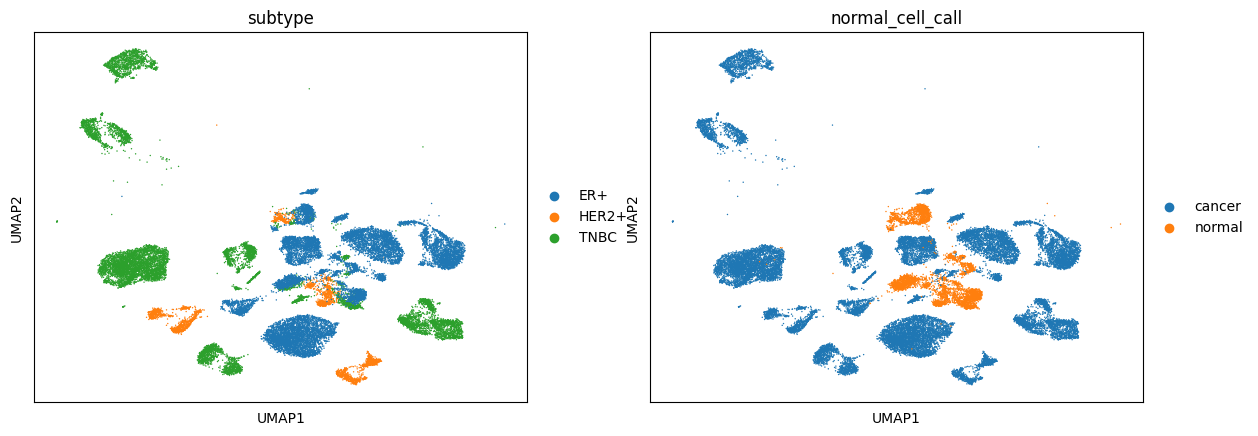

In [16]:
sc.pl.umap(adata_bc_epi, color=["subtype", "normal_cell_call"])

/home/marii/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/marii/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


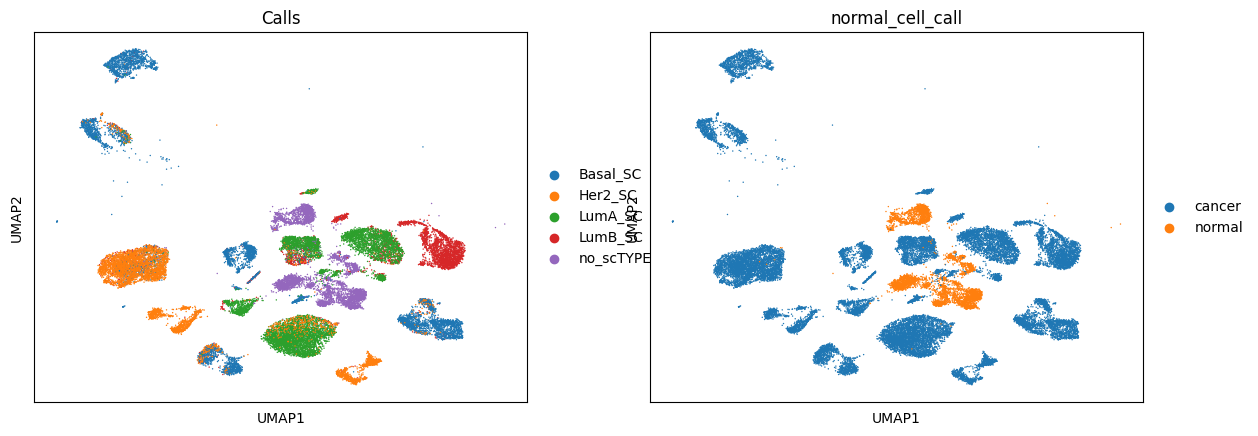

In [17]:
sc.pl.umap(adata_bc_epi, color=["Calls", "normal_cell_call"])

/home/marii/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


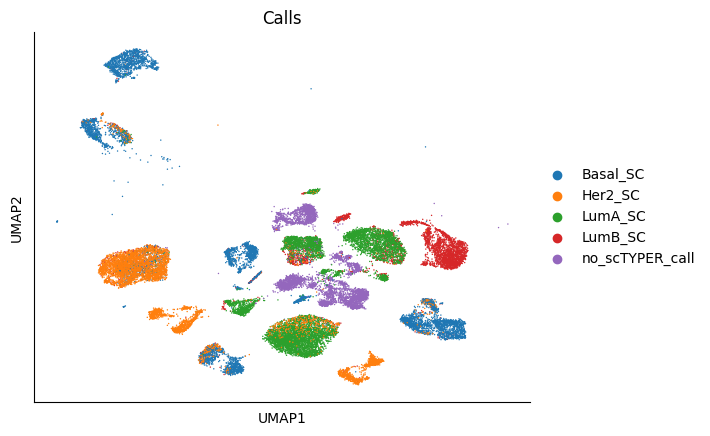

In [18]:
fig, ax = plt.subplots()

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

sc.pl.umap(adata_bc_epi, color="Calls", ax=ax)

In [19]:
adata_bc_epi.obs.Calls.value_counts()

LumA_SC            7943
Basal_SC           6631
Her2_SC            5711
no_scTYPER_call    4355
LumB_SC            4204
Name: Calls, dtype: int64

In [20]:
sc.tl.rank_genes_groups(adata_bc_epi, groupby='Calls', method='wilcoxon', use_raw=False, reference='no_scTYPER_call')

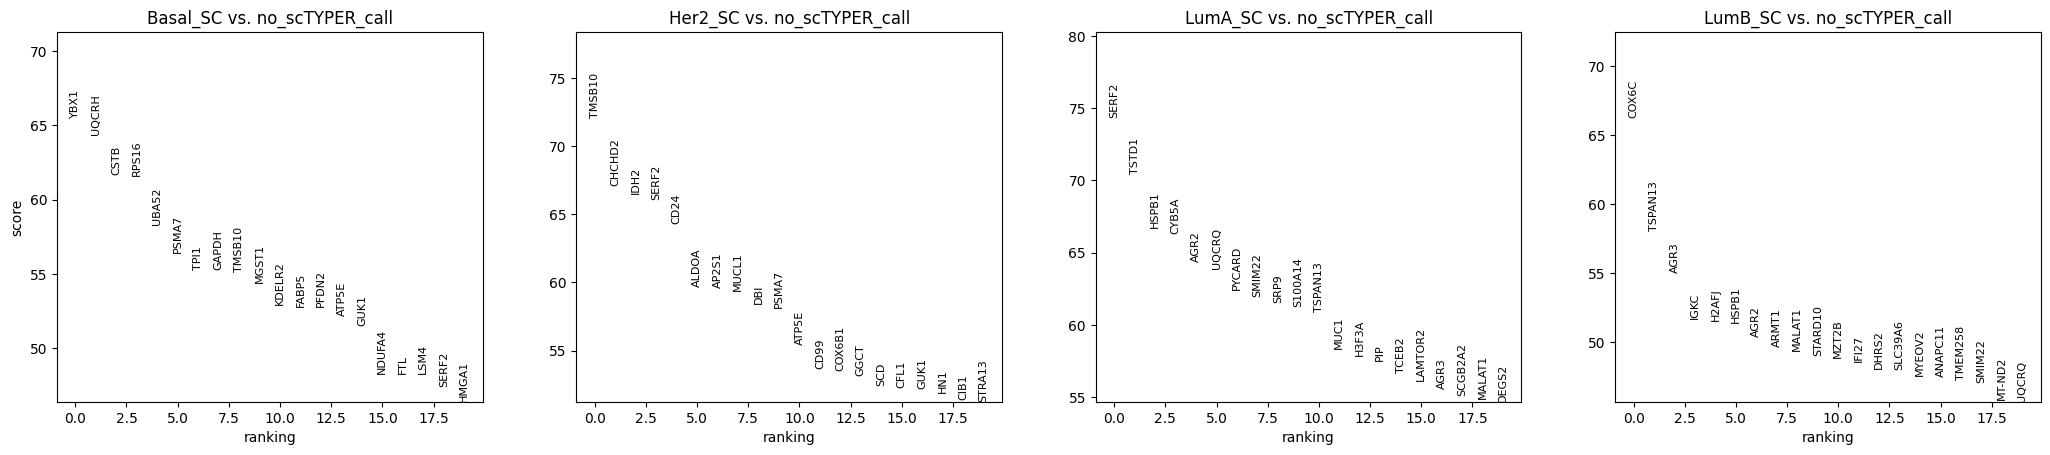

In [21]:
sc.pl.rank_genes_groups(adata_bc_epi, sharey=False)#, gene_symbols="feature_name")

## Basal cells

In [22]:
bas_disreg_enrich = pd.DataFrame()
bas_omim_enrich = pd.DataFrame()
bas_cosmic_enrich = pd.DataFrame()
megaheat = pd.DataFrame()

In [23]:
de_genes = sc.get.rank_genes_groups_df(adata_bc_epi, group=None,  pval_cutoff=1e-2)

de_genes = de_genes[de_genes.group == "Basal_SC"]

de_genes.index = pd.MultiIndex.from_frame(de_genes[["names", "group"]])
de_genes

de_genes = de_genes["logfoldchanges"].unstack(level=1).T
de_genes.head()

de_genes = de_genes.loc[:, ~de_genes.T.Basal_SC.isna().T]

In [24]:
enr = gp.enrich(de_genes.loc[:, (de_genes.T.Basal_SC.abs() > 1).T].columns.to_list(), "DisGeNET")

enr.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,DisGeNET,Mammary Neoplasms,627/2387,4.472380e-37,3.971920e-33,0,0,1.959967,164.044766,CDA;SERPINE2;SERPINE1;ENO1;ALKBH8;MYLK;PREX1;G...
1,DisGeNET,Breast Carcinoma,1114/4963,1.146474e-34,5.090916e-31,0,0,1.669213,130.451026,C4BPA;ALKBH8;MYLK;PREX1;NDST1;PSMD4;TDO2;ZC3H1...
2,DisGeNET,Malignant neoplasm of breast,1117/5054,1.113718e-31,3.296978e-28,0,0,1.627258,115.978660,POP1;ACCS;ALKBH8;MYLK;PREX1;NDST1;PSMD4;TDO2;Z...
3,DisGeNET,Neoplasm Metastasis,900/3920,3.026663e-30,6.719950e-27,0,0,1.669168,113.453488,ACCS;MYLK;PREX1;ZEB1-AS1;PSMD4;TDO2;PSMD2;ZC3H...
4,DisGeNET,Carcinogenesis,925/4065,9.539012e-30,1.694319e-26,0,0,1.652418,110.418175,C4BPA;PREX1;ZEB1-AS1;PSMD4;ZC3H12A;CKMT1B;WLS;...
...,...,...,...,...,...,...,...,...,...,...
8876,DisGeNET,Neuronal Ceroid-Lipofuscinoses,1/39,9.991920e-01,9.994409e-01,0,0,0.131192,0.000106,CTSF
8877,DisGeNET,Orbital separation diminished,1/39,9.991920e-01,9.994409e-01,0,0,0.131192,0.000106,GJA1
8878,DisGeNET,Congenital Bilateral Cataracts,4/75,9.992476e-01,9.994409e-01,0,0,0.280557,0.000211,CAV1;SORD;SDHD;EPHA2
8879,DisGeNET,Night Blindness,10/132,9.993283e-01,9.994409e-01,0,0,0.407667,0.000274,SEMA4A;ADGRV1;FAM161A;IMPDH1;MAK;FLVCR1;RP9;RE...


CollecTri

In [25]:
tf_acts_ctri, tf_pvals_ctri = dc.run_ulm(de_genes, collectri, weight=None)

In [26]:
mask_ctri = tf_pvals_ctri < 0.01

active_tfs_ctri = tf_acts_ctri.loc[:, pd.DataFrame(tf_acts_ctri * mask_ctri).sum(axis=0) != 0].columns.to_list()

In [27]:
tf_acts_ctri.index = ["score"]
tf_pvals_ctri.index = ["p_value"]
out_ctri = pd.merge(left=tf_acts_ctri.T, right=tf_pvals_ctri.T, left_index=True, right_index=True)
out_ctri.to_csv("../data/3-tf_activity/bc_bas_activity_collectri.tsv", sep="\t", index=False)

In [28]:
enr = gp.enrich(active_tfs_ctri, "OMIM_Expanded")
enr.results["Network"] = "CollecTri"
enr.results.to_csv("../data/3-tf_disease_enrichment/bc_omim_enrich_collectri_bas.tsv", sep="\t", index=False)
bas_omim_enrich = pd.concat([bas_omim_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [29]:
enr = gp.enrich(active_tfs_ctri, "DisGeNET")
enr.results["Network"] = "CollecTri"
enr.results.to_csv("../data/3-tf_disease_enrichment/bc_disgenet_enrich_collectri_bas.tsv", sep="\t", index=False)
bas_disreg_enrich = pd.concat([bas_disreg_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [30]:
try:
    enr = gp.enrich(gene_list=active_tfs_ctri, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "CollecTri"
    enr.results.to_csv("../data/3-tf_disease_enrichment/bc_cosmic_enrich_collectri_bas.tsv", sep="\t", index=False)
    bas_cosmic_enrich = pd.concat([bas_cosmic_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "CollecTri"
    bas_cosmic_enrich = pd.concat([bas_cosmic_enrich, pd.DataFrame()], axis=0)

In [31]:
heat = pd.concat([tf_acts_ctri.rename({"Basal_SC": "score"}), tf_pvals_ctri.rename({"Basal_SC": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("leukemic", ascending=False).index).head(5)
heat["Network"] = "CollecTri"
#heat["TFs"] = heat.index
megaheat = pd.concat([megaheat, heat], axis =0)
megaheat.describe()

,score,p_value
count,97.000000,9.700000e+01
mean,-0.612665,2.834497e-01
std,1.879469,2.893768e-01
min,-4.942216,3.705592e-11
25%,-1.820985,3.162176e-02
50%,-0.746405,1.340644e-01
75%,0.333257,5.211877e-01
max,6.624145,9.557009e-01


MCF7

In [32]:
tf_acts_mcf7, tf_pvals_mcf7 = dc.run_ulm(de_genes, mcf7, source='tf', target='gene_symbol', weight=None)

In [33]:
mask_mcf7 = tf_pvals_mcf7 < 0.01

active_tfs_mcf7 = tf_acts_mcf7.loc[:, pd.DataFrame(tf_acts_mcf7 * mask_mcf7).sum(axis=0) != 0].columns.to_list()

In [34]:
tf_acts_mcf7.index = ["score"]
tf_pvals_mcf7.index = ["p_value"]
out_mcf7 = pd.merge(left=tf_acts_mcf7.T, right=tf_pvals_mcf7.T, left_index=True, right_index=True)
out_mcf7.to_csv("../data/3-tf_activity/bc_bas_activity_m2kb.tsv", sep="\t", index=False)

In [35]:
enr = gp.enrich(active_tfs_mcf7, "OMIM_Expanded")
enr.results["Network"] = "M2Kb_MCF-7"
enr.results.to_csv("../data/3-tf_disease_enrichment/bc_omim_enrich_m2kb_mcf7_bas.tsv", sep="\t", index=False)
bas_omim_enrich = pd.concat([bas_omim_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [36]:
enr = gp.enrich(active_tfs_mcf7, "DisGeNET")
enr.results["Network"] = "M2Kb_MCF-7"
enr.results.to_csv("../data/3-tf_disease_enrichment/bc_disgenet_enrich_m2kb_mcf7_bas.tsv", sep="\t", index=False)
bas_disreg_enrich = pd.concat([bas_disreg_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [37]:
try:
    enr = gp.enrich(gene_list=active_tfs_mcf7, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "M2Kb_MCF-7"
    enr.results.to_csv("../data/3-tf_disease_enrichment/bc_cosmic_enrich_m2kb_mcf7_bas.tsv", sep="\t", index=False)
    bas_cosmic_enrich = pd.concat([bas_cosmic_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "M2Kb_MCF-7"
    bas_cosmic_enrich = pd.concat([bas_cosmic_enrich, pd.DataFrame()], axis=0)

In [38]:
heat = pd.concat([tf_acts_mcf7.rename({"Basal_SC": "score"}), tf_pvals_mcf7.rename({"Basal_SC": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("leukemic", ascending=False).index).head(5)
heat["Network"] = "M2Kb_MCF-7"
#heat["TFs"] = heat.index
megaheat = pd.concat([megaheat, heat], axis =0)
megaheat

,score,p_value,Network
AHR,-1.790777,7.336471e-02,CollecTri
AR,-4.942216,7.872029e-07,CollecTri
ARID3A,1.807913,7.065547e-02,CollecTri
ARNT,-1.557487,1.193924e-01,CollecTri
ATF7,-1.570417,1.163555e-01,CollecTri
...,...,...,...
ZNF217,-2.820742,4.802415e-03,M2Kb_MCF-7
ZNF24,-3.373961,7.442730e-04,M2Kb_MCF-7
ZNF444,-4.190881,2.806963e-05,M2Kb_MCF-7
ZNF512B,-3.854342,1.168991e-04,M2Kb_MCF-7


chip_atlas_mcf7

In [39]:
tf_acts_chip_atlas_mcf7, tf_pvals_chip_atlas_mcf7 = dc.run_ulm(de_genes, chip_atlas_mcf7.drop_duplicates(), source='tf', target='Target_genes', weight=None)

#tf_pvals_chip_atlas_mcf7.loc["Basal_SC"] = fdrcorrection(tf_pvals_chip_atlas_mcf7.T["Basal_SC"])[1]

In [40]:
mask_chip_atlas_mcf7 = tf_pvals_chip_atlas_mcf7 < 0.01

active_tfs_chip_atlas_mcf7 = tf_acts_chip_atlas_mcf7.loc["Basal_SC", pd.DataFrame(tf_acts_chip_atlas_mcf7 * mask_chip_atlas_mcf7).sum(axis=0) != 0].index.to_list()
tf_acts_chip_atlas_mcf7.loc["Basal_SC", pd.DataFrame(tf_acts_chip_atlas_mcf7 * mask_chip_atlas_mcf7).sum(axis=0) != 0]

AHR       -4.016224
AR        -3.903622
ARID1A    -6.377027
ARID1B    -4.682735
ARNT      -3.199601
BRD4      -6.109159
CREBBP    -2.896095
CTBP2     -2.844501
CTCF      -4.684923
E2F1      -3.498319
E2F4       8.548873
E2F8       4.473659
EGR1      -3.399185
EP300     -6.932015
ERG       -5.973702
ESR1      -7.317427
ESR2      -4.443055
FOS       -4.185774
FOSL2     -3.145680
FOXA1     -5.554205
GATA3     -5.662894
GRHL1     -3.806424
GRHL2     -4.717084
GTF2F1    -4.334548
JUN       -4.606369
JUNB      -4.356730
JUND      -3.377950
KDM5B     -7.262698
MAX       -4.454880
MED1      -4.400178
MED12     -3.203305
MSX2      -2.618739
MTA3      -2.882341
MYC       -5.902119
NCOA3     -6.593267
NR2F2     -6.059735
NR3C1     -2.932870
NRIP1     -6.314315
PGR       -5.743792
PML       -3.030964
RB1        6.073056
REST      -3.002976
SIN3A     -4.152451
SMARCA4   -5.920322
SMARCB1   -3.463574
SMARCC1   -3.013831
STAT3     -4.742445
TAF1      -6.297253
TCF12     -2.806563
TEAD4     -3.162290


In [41]:
tf_acts_chip_atlas_mcf7.index = ["score"]
tf_pvals_chip_atlas_mcf7.index = ["p_value"]
out_chip_atlas_mcf7 = pd.merge(left=tf_acts_chip_atlas_mcf7.T, right=tf_pvals_chip_atlas_mcf7.T, left_index=True, right_index=True)
out_chip_atlas_mcf7.to_csv("../data/3-tf_activity/bc_bas_activity_ca_mcf7.tsv", sep="\t", index=False)

In [42]:
try:    
    enr = gp.enrich(active_tfs_chip_atlas_mcf7, "OMIM_Expanded")
    enr.results["Network"] = "CA_MCF-7"
    enr.results.to_csv("../data/3-tf_disease_enrichment/bc_omim_enrich_ca_mcf7_bas.tsv", sep="\t", index=False)
    bas_omim_enrich = pd.concat([bas_omim_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except:
    enr.results["Network"] = "CA_MCF-7"
    bas_omim_enrich = pd.concat([bas_omim_enrich, pd.DataFrame()], axis=0)

In [43]:
try:    
    enr = gp.enrich(active_tfs_chip_atlas_mcf7, "DisGeNET")
    enr.results["Network"] = "CA_MCF-7"
    enr.results.to_csv("../data/3-tf_disease_enrichment/bc_disgenet_enrich_ca_mcf7_bas.tsv", sep="\t", index=False)
    bas_disreg_enrich = pd.concat([bas_disreg_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except:
    enr.results["Network"] = "CA_MCF-7"
    bas_disreg_enrich = pd.concat([bas_disreg_enrich, pd.DataFrame()], axis=0)

In [44]:
try:
    enr = gp.enrich(gene_list=active_tfs_chip_atlas_mcf7, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "CA_MCF-7"
    enr.results.to_csv("../data/3-tf_disease_enrichment/bc_cosmic_enrich_ca_mcf7_bas.tsv", sep="\t", index=False)
    bas_cosmic_enrich = pd.concat([bas_cosmic_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "CA_MCF-7"
    bas_cosmic_enrich = pd.concat([bas_cosmic_enrich, pd.DataFrame()], axis=0)

In [45]:
heat = pd.concat([tf_acts_chip_atlas_mcf7.rename({"Basal_SC": "score"}), tf_pvals_chip_atlas_mcf7.rename({"Basal_SC": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("Basal_SC", ascending=False).index).head(5)
heat["Network"] = "CA_MCF-7"
#heat["TFs"] = heat.index
megaheat = pd.concat([megaheat, heat], axis =0)
megaheat

,score,p_value,Network
AHR,-1.790777,7.336471e-02,CollecTri
AR,-4.942216,7.872029e-07,CollecTri
ARID3A,1.807913,7.065547e-02,CollecTri
ARNT,-1.557487,1.193924e-01,CollecTri
ATF7,-1.570417,1.163555e-01,CollecTri
...,...,...,...
ZNF217,-0.722520,4.699946e-01,CA_MCF-7
ZNF24,0.206623,8.363093e-01,CA_MCF-7
ZNF444,-1.915276,5.549100e-02,CA_MCF-7
ZNF512B,-0.291218,7.708915e-01,CA_MCF-7


Plotting results

In [46]:
okabe = [pal[0], pal[7], pal[3]]

/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/bc_go_enrich_omim_bas.svg


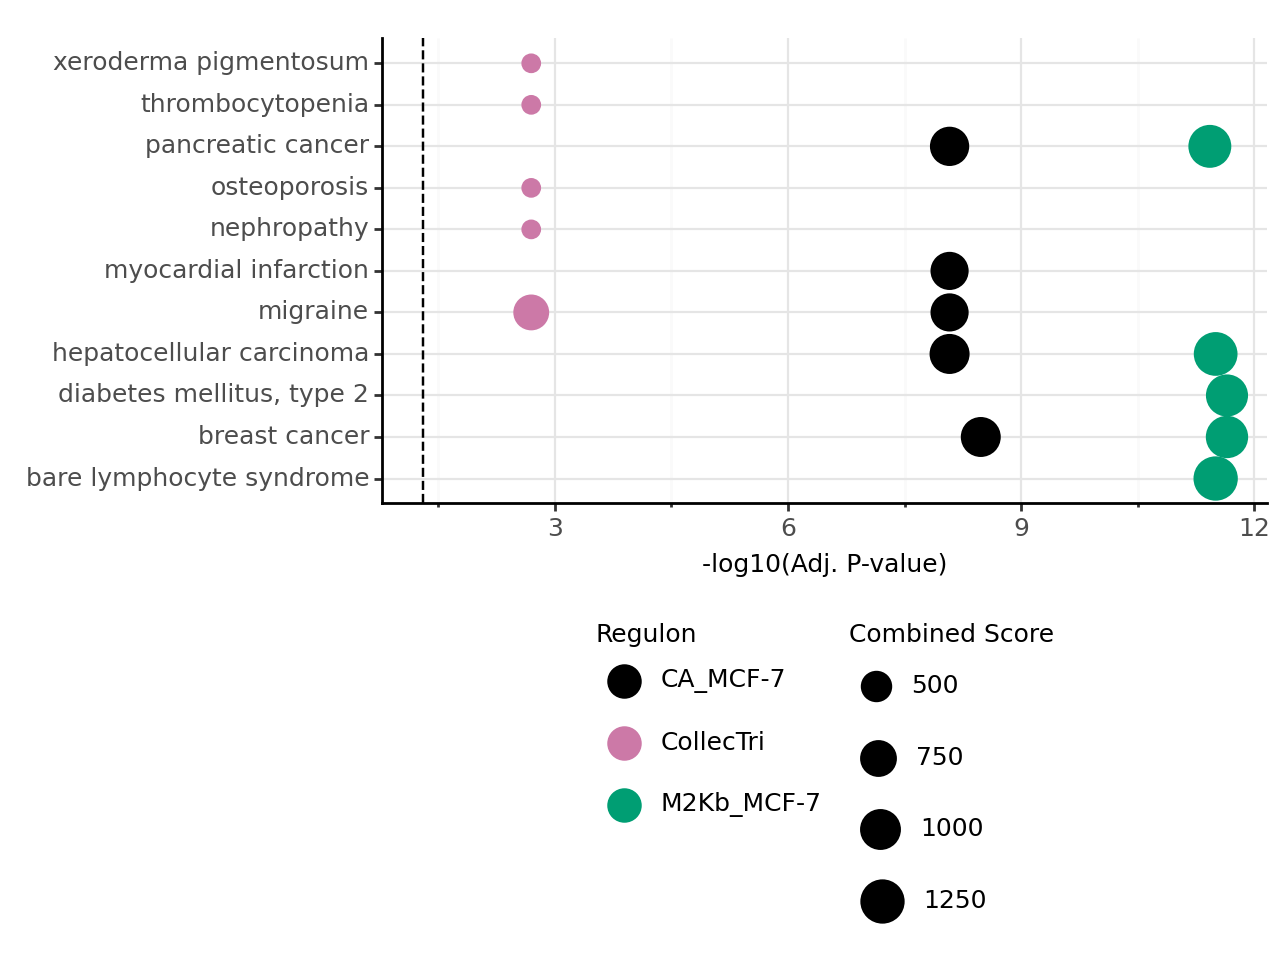

<Figure Size: (640 x 480)>

In [47]:
bas_omim_enrich["-log10(Adj. P-value)"] = - np.log10(bas_omim_enrich["Adjusted P-value"])
bas_omim_enrich = bas_omim_enrich.loc[bas_omim_enrich["Adjusted P-value"] < 0.05]
bas_omim_enrich.describe()

p = plot_enrich(bas_omim_enrich, okabe)
ggsave(p, "../plots/3-tf_disease_enrichment/bc_go_enrich_omim_bas.svg", width = 30, height = 150, units = "mm", dpi=720)
p

/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/bc_go_enrich_disreg_bas.svg


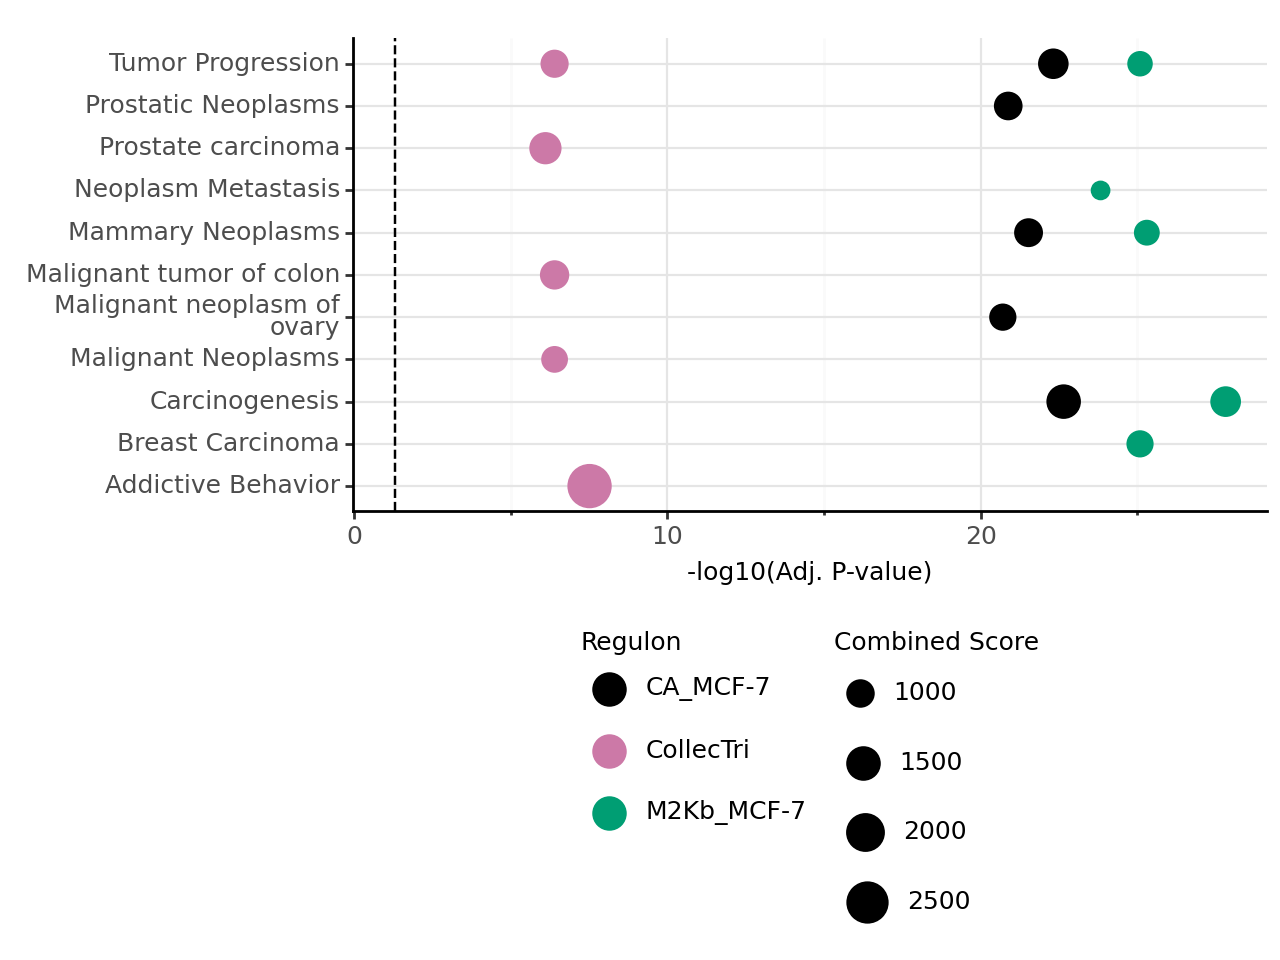

<Figure Size: (640 x 480)>

In [48]:
bas_disreg_enrich["-log10(Adj. P-value)"] = - np.log10(bas_disreg_enrich["Adjusted P-value"])
bas_disreg_enrich = bas_disreg_enrich.loc[bas_disreg_enrich["Adjusted P-value"] < 0.05]
bas_disreg_enrich.describe()

p = plot_enrich(bas_disreg_enrich, okabe)
ggsave(p, "../plots/3-tf_disease_enrichment/bc_go_enrich_disreg_bas.svg", width = 30, height = 150, units = "mm", dpi=720)
p

/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/bc_go_enrich_cosmic_bas.svg


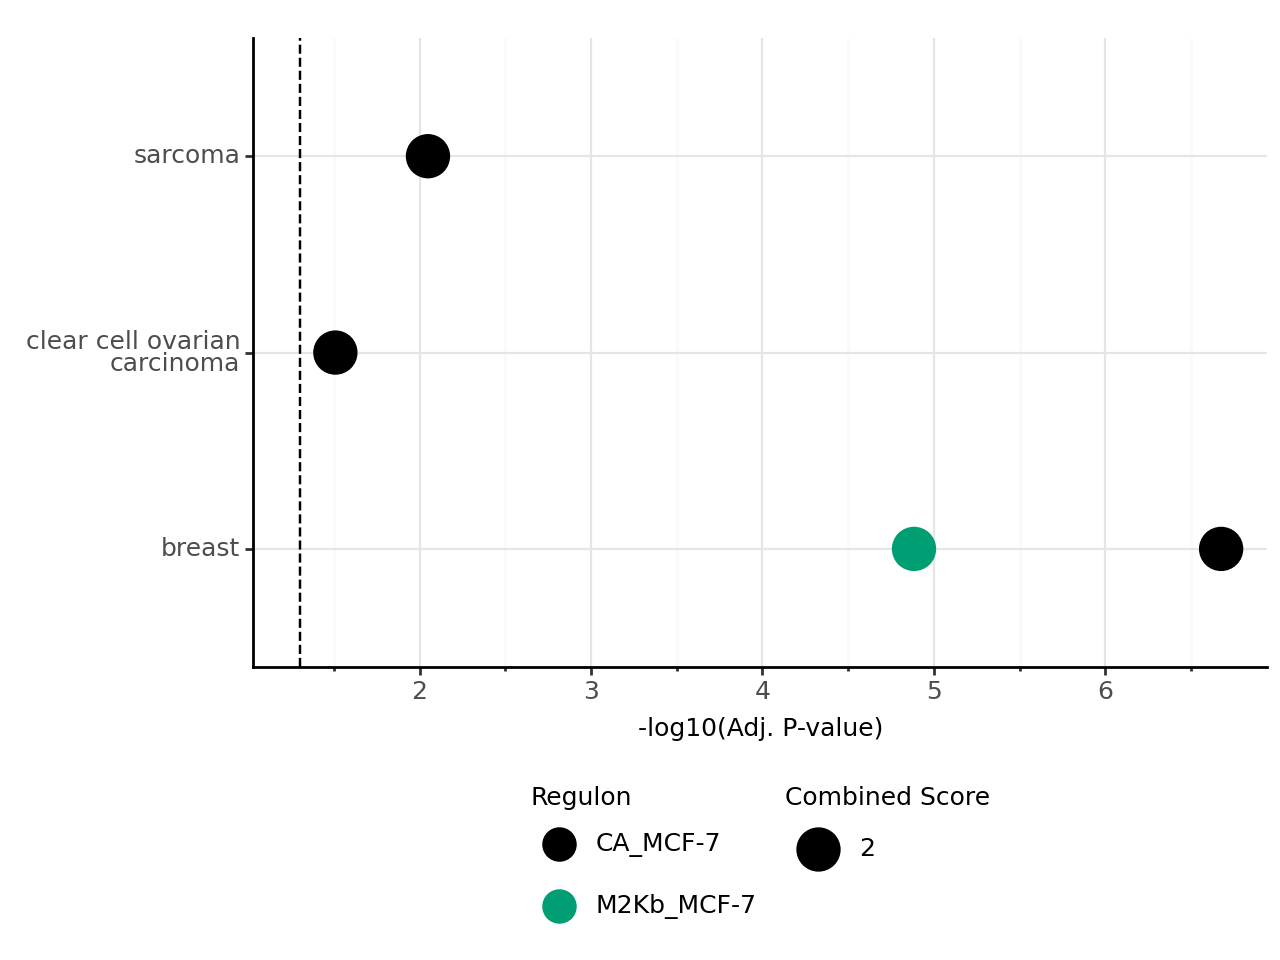

<Figure Size: (640 x 480)>

In [49]:
bas_cosmic_enrich["-log10(Adj. P-value)"] = - np.log10(bas_cosmic_enrich["Adjusted P-value"])
bas_cosmic_enrich = bas_cosmic_enrich.loc[bas_cosmic_enrich["Adjusted P-value"] < 0.05]
bas_cosmic_enrich.describe()

temp_pal = [okabe[0], okabe[2]]
p = plot_enrich(bas_cosmic_enrich, temp_pal, size=2)
ggsave(p, "../plots/3-tf_disease_enrichment/bc_go_enrich_cosmic_bas.svg",  width = 30, height = 150, units = "mm", dpi=720)
p

In [50]:
megaheat.to_csv("../data/3-tf_activity/bc_activity_estimates_bas.tsv", sep="\t", index=False)

In [51]:
megaheat

,score,p_value,Network
AHR,-1.790777,7.336471e-02,CollecTri
AR,-4.942216,7.872029e-07,CollecTri
ARID3A,1.807913,7.065547e-02,CollecTri
ARNT,-1.557487,1.193924e-01,CollecTri
ATF7,-1.570417,1.163555e-01,CollecTri
...,...,...,...
ZNF217,-0.722520,4.699946e-01,CA_MCF-7
ZNF24,0.206623,8.363093e-01,CA_MCF-7
ZNF444,-1.915276,5.549100e-02,CA_MCF-7
ZNF512B,-0.291218,7.708915e-01,CA_MCF-7


In [52]:
megaheat = megaheat[megaheat.p_value < 0.01].sort_values("score")
megaheat["TF"] = megaheat.index
megaheat["log_p"] = - np.log10(megaheat.p_value).round(0)
#megaheat["log_p"] = megaheat["log_p"].astype("str")

In [53]:
print(megaheat[megaheat.Network == "M2Kb_MCF-7"].sort_values("score").to_string())

            score       p_value     Network       TF  log_p
ARID1B  -7.261983  4.152218e-13  M2Kb_MCF-7   ARID1B   12.0
EP300   -7.251988  4.468467e-13  M2Kb_MCF-7    EP300   12.0
GATA3   -6.630306  3.554941e-11  M2Kb_MCF-7    GATA3   10.0
SMARCA4 -6.338774  2.434352e-10  M2Kb_MCF-7  SMARCA4   10.0
JUN     -6.305190  3.022410e-10  M2Kb_MCF-7      JUN   10.0
SMARCC1 -6.169740  7.154020e-10  M2Kb_MCF-7  SMARCC1    9.0
NR2F2   -6.165171  7.362730e-10  M2Kb_MCF-7    NR2F2    9.0
NR3C1   -6.154110  7.892876e-10  M2Kb_MCF-7    NR3C1    9.0
REST    -5.918839  3.368347e-09  M2Kb_MCF-7     REST    8.0
BRD4    -5.586224  2.392429e-08  M2Kb_MCF-7     BRD4    8.0
MSX2    -5.561269  2.759655e-08  M2Kb_MCF-7     MSX2    8.0
CTCF    -5.394641  7.051370e-08  M2Kb_MCF-7     CTCF    7.0
ARID1A  -5.377088  7.771717e-08  M2Kb_MCF-7   ARID1A    7.0
MED1    -5.201281  2.025503e-07  M2Kb_MCF-7     MED1    7.0
TAF1    -5.115286  3.201333e-07  M2Kb_MCF-7     TAF1    6.0
ESR1    -4.933760  8.219770e-07  M2Kb_MC

In [54]:
megaheat.sort_values(["score"])

,score,p_value,Network,TF,log_p
ESR1,-7.317427,2.758520e-13,CA_MCF-7,ESR1,13.0
KDM5B,-7.262698,4.130448e-13,CA_MCF-7,KDM5B,12.0
ARID1B,-7.261983,4.152218e-13,M2Kb_MCF-7,ARID1B,12.0
EP300,-7.251988,4.468467e-13,M2Kb_MCF-7,EP300,12.0
EP300,-6.932015,4.452778e-12,CA_MCF-7,EP300,11.0
...,...,...,...,...,...
E2F8,4.654204,3.301765e-06,M2Kb_MCF-7,E2F8,5.0
RB1,6.073056,1.309049e-09,CA_MCF-7,RB1,9.0
E2F4,6.624145,3.705592e-11,CollecTri,E2F4,10.0
E2F4,7.492584,7.432584e-14,M2Kb_MCF-7,E2F4,13.0


/crex/proj/lappalainen_lab1/users/marii/chip_seq_ann/case_studies/plot_lib.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
/crex/proj/lappalainen_lab1/users/marii/chip_seq_ann/case_studies/plot_lib.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator


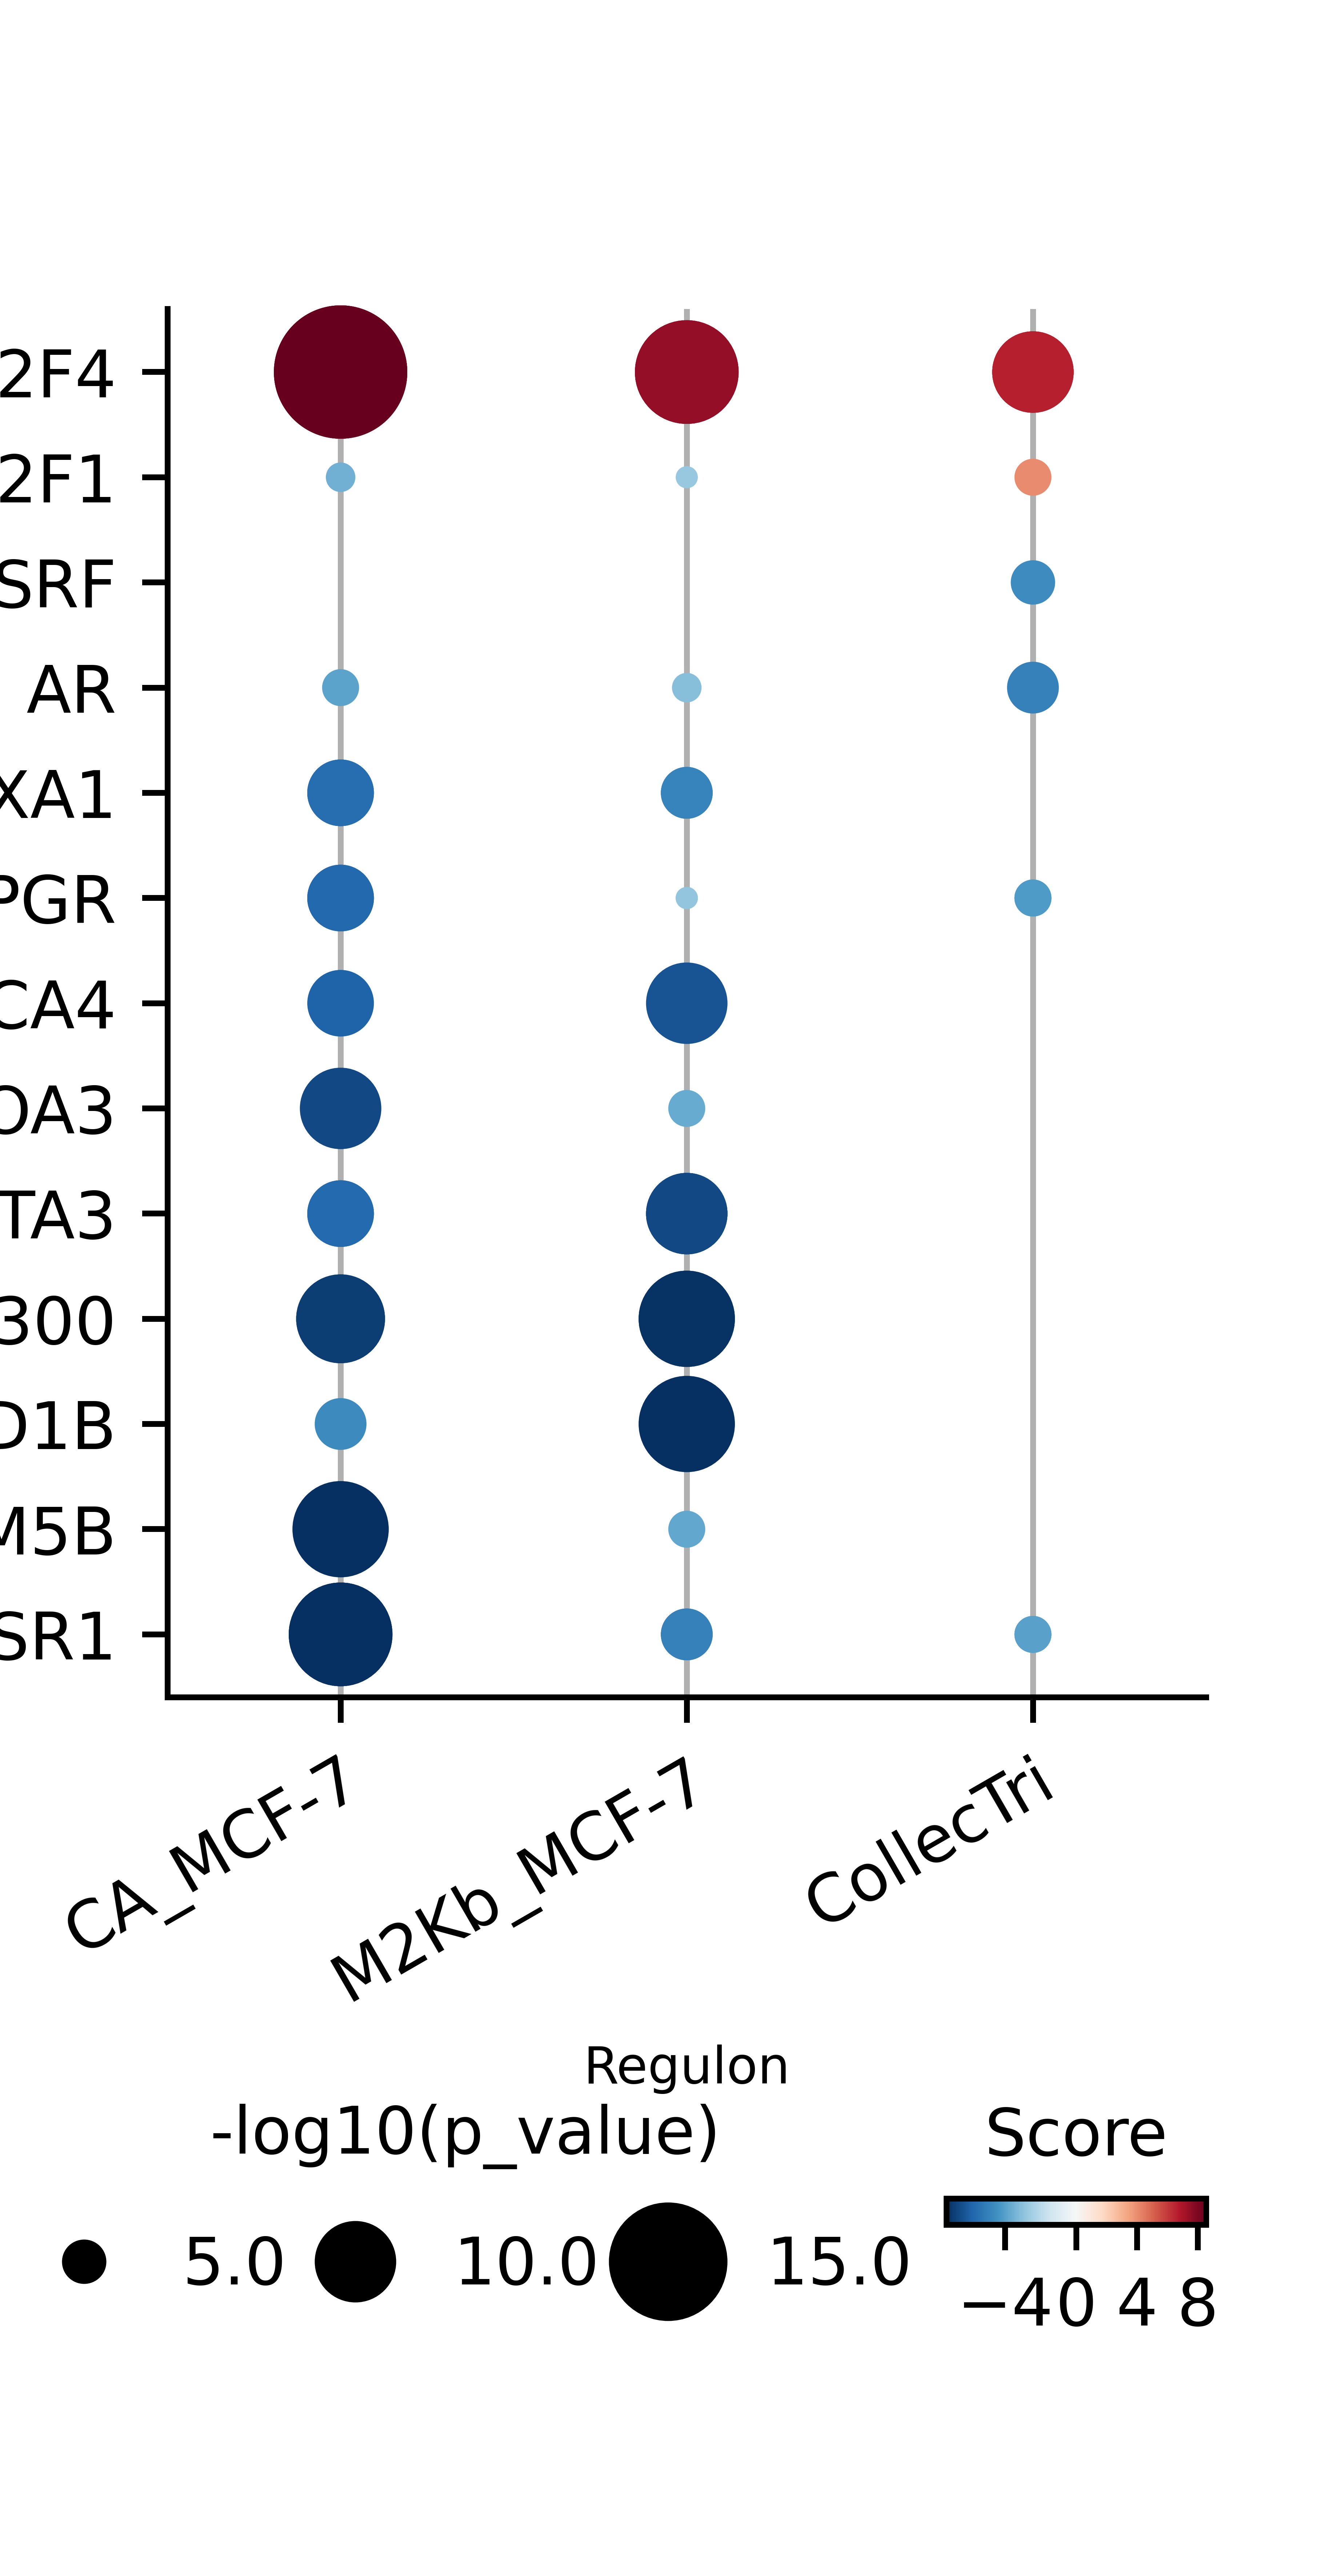

In [55]:
out = pd.DataFrame()
interesting_tf = ["ESR1", "PGR", "GATA3", "FOXA1"]
for net in ["M2Kb_MCF-7", "CollecTri", "CA_MCF-7"]:
    mask = megaheat[megaheat.Network == net].score.abs().sort_values(ascending=False).head(5).index
    out = pd.concat([out, megaheat.loc[megaheat.TF.isin(mask) | megaheat.TF.isin(interesting_tf), :]])
plot_bubbles(out[out.Network.isin(["CollecTri", "M2Kb_MCF-7", "CA_MCF-7"])], scale=0.17)
plt.savefig("../plots/3-tf_activity/bc_activity_clustermap_bas.svg", dpi=720, format="svg")